# 10x scRNA-seq gene expression data (part 1)

To efficiently handle data transfer and download, this large > 4 million cell 10X dataset, was subdivided the 10x gene into 23 gene expression packages where cells are grouped by method (10Xv2 vs 10Xv3) and the broad anatomical region from where the cells were dissected from.

The purpose of this set of notebooks is to provide an overview of the data, the file organization and how to combine data and metadata through example use cases.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

In [2]:
input_base = '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff'
input_directory = os.path.join( input_base, 'dataframes', 'WMB-10X','20230630' )

view_directory = os.path.join( input_directory, 'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data overview
### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database.

Each cell is associated with a *library label*, *library method*, *donor label*, *donor genotype*, *donor sex*, dissection *region of interest acronym", the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of.

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x,y) coordinates of the all cells UMAP in Figure 1 of the manuscript.


In [3]:
file = os.path.join( input_directory, 'cell_metadata.csv')
cell = pd.read_csv(file)
cell.set_index('cell_label',inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

Number of cells =  4057701


,library_label,anatomical_division_label,cluster_alias,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,matrix_prefix,x,y
cell_label,,,,,,,,,,,,
GACTGCGAGCTGCAAG-020_C01,L8TX_180406_01_F01,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,-6.997189,-10.805128
CGATGTAGTGCTAGCC-021_D01,L8TX_180406_01_C02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381295,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,WMB-10Xv2,WMB-10Xv2-HPF,-6.526481,-10.935798
CACATAGCATGGTTGT-020_D01,L8TX_180406_01_B02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,-6.673367,-10.980438
CCTAAAGGTGACCAAG-020_C01,L8TX_180406_01_F01,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,-6.980066,-10.790136
CGGAGCTAGCTTTGGT-021_D01,L8TX_180406_01_C02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381295,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,WMB-10Xv2,WMB-10Xv2-HPF,-6.490485,-10.884357


We can use panadas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [4]:
def print_column_info(df) :
    
    for c in df.columns :
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30 :
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped),members))
        

In [5]:
print_column_info(cell)

Number of unique library_label = 781 
Number of unique anatomical_division_label = 12 ['CB', 'CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'MY', 'OLF', 'P', 'PAL', 'STR', 'TH']
Number of unique cluster_alias = 5196 
Number of unique library_method = 2 ['10Xv2', '10Xv3']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SSp', 'STRd', 'STRv', 'TEa-PERI-ECT', 'TH', 'VIS', 'VIS-PTLp', 'sAMY']
Number of unique donor_label = 318 
Number of unique donor_genotype = 4 ['Ai14(RCL-tdT)/wt', 'Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt', 'Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt', 'Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt']
Number of unique donor_sex = 2 ['F', 'M']
Number of unique dataset_label = 2 ['WMB-10Xv2', 'WMB-10Xv3']
Number of unique matrix_prefix = 23 ['WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-I

We can also bring in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level.

In [6]:
file = os.path.join( input_directory, '..', '..','WMB-taxonomy', '20230630', 'views',
             'cluster_to_cluster_annotation_membership_pivoted.csv')
cluster_details = pd.read_csv(file)
cluster_details.set_index('cluster_alias', inplace=True)
cluster_details.head(5)

,neurotransmitter,division,class,subclass,supertype,cluster
cluster_alias,,,,,,
1,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
2,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0328 L2 IT PPP-APr Glut_3
3,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
4,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0324 L2 IT PPP-APr Glut_2
5,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0326 L2 IT PPP-APr Glut_2


In [7]:
file = os.path.join( input_directory, '..', '..', 'WMB-taxonomy', '20230630', 'views',
             'cluster_to_cluster_annotation_membership_color.csv')
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)
cluster_colors.head(5)

,neurotransmitter_color,division_color,class_color,subclass_color,supertype_color,cluster_color
cluster_alias,,,,,,
1,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C
2,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#280099
3,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#5CCCA0
4,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#CC6D1F
5,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#FF8E26


In [8]:
file = os.path.join( input_directory, 'region_of_interest_metadata.csv')
roi = pd.read_csv(file)
roi.set_index('acronym',inplace=True)
roi.rename(columns={'order':'region_of_interest_order','color_hex_triplet':'region_of_interest_color'},inplace=True)
roi.head(5)

,label,name,region_of_interest_order,region_of_interest_color
acronym,,,,
MO-FRP,WMB-MO-FRP,Somatomotor - Frontal pole,0,#3DCC7C
MOp,WMB-MOp,Primary motor area,1,#179968
SS-GU-VISC,WMB-SS-GU-VISC,Somatosensory/gustatory/visceral areas,2,#2E8599
SSp,WMB-SSp,Primary somatosensory area,3,#5CCCCC
AUD,WMB-AUD,Auditory areas,4,#455A99


In [9]:
cell_extended = cell.join(cluster_details,on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors,on='cluster_alias')
cell_extended = cell_extended.join(roi[['region_of_interest_order','region_of_interest_color']],on='region_of_interest_acronym')
cell_extended.head(5)

,library_label,anatomical_division_label,cluster_alias,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,matrix_prefix,...,supertype,cluster,neurotransmitter_color,division_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
GACTGCGAGCTGCAAG-020_C01,L8TX_180406_01_F01,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,...,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C,15,#CCB05C
CGATGTAGTGCTAGCC-021_D01,L8TX_180406_01_C02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381295,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,WMB-10Xv2,WMB-10Xv2-HPF,...,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C,15,#CCB05C
CACATAGCATGGTTGT-020_D01,L8TX_180406_01_B02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,...,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C,15,#CCB05C
CCTAAAGGTGACCAAG-020_C01,L8TX_180406_01_F01,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381293,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv2,WMB-10Xv2-HPF,...,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C,15,#CCB05C
CGGAGCTAGCTTTGGT-021_D01,L8TX_180406_01_C02,HPF,1,10Xv2,RHP,Snap25-IRES2-Cre;Ai14-381295,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,F,WMB-10Xv2,WMB-10Xv2-HPF,...,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C,15,#CCB05C


In [10]:
print_column_info(cell_extended)

Number of unique library_label = 781 
Number of unique anatomical_division_label = 12 ['CB', 'CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'MY', 'OLF', 'P', 'PAL', 'STR', 'TH']
Number of unique cluster_alias = 5196 
Number of unique library_method = 2 ['10Xv2', '10Xv3']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SSp', 'STRd', 'STRv', 'TEa-PERI-ECT', 'TH', 'VIS', 'VIS-PTLp', 'sAMY']
Number of unique donor_label = 318 
Number of unique donor_genotype = 4 ['Ai14(RCL-tdT)/wt', 'Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt', 'Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt', 'Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt']
Number of unique donor_sex = 2 ['F', 'M']
Number of unique dataset_label = 2 ['WMB-10Xv2', 'WMB-10Xv3']
Number of unique matrix_prefix = 23 ['WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-I

For convenience, we can cache this view for later reuse. 

In [11]:
if cache_views :
    file = os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv')
    cell_extended.to_csv( file )

### UMAP spatial embedding

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. The x, y columns of the cell metadata table represents the coordinate of the all cells UMAP in Figure 1 of the manuscript. 

We define a small helper function *plot umap* to visualize the cells on the UMAP colorized by: dissection region of interest, neurotransmitter identity, cell types division, class and subclass. For ease of demostration, we do a simple subsampling of the cells by a factor of 10 to reduce processing time.

In [12]:
def plot_umap( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    fig_width = 10
    fig_height = 10
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
    return fig, ax

In [13]:
cell_subsampled = cell_extended.loc[::10]
print(len(cell_subsampled))

405771


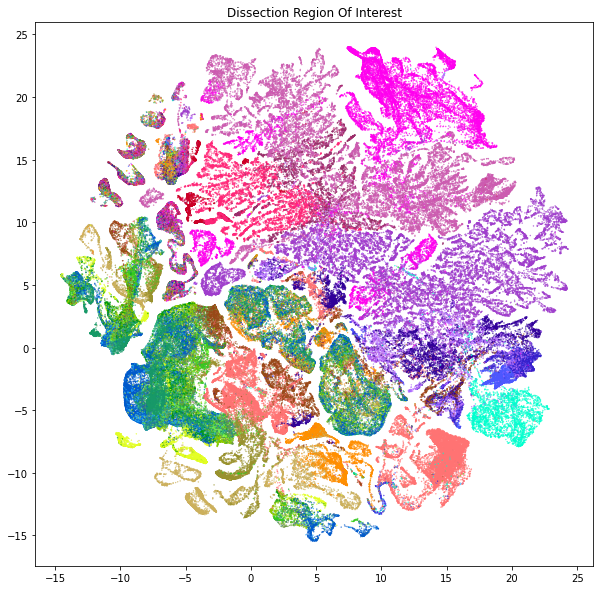

In [14]:
fig, ax = plot_umap( cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['region_of_interest_color'])
res = ax.set_title("Dissection Region Of Interest")

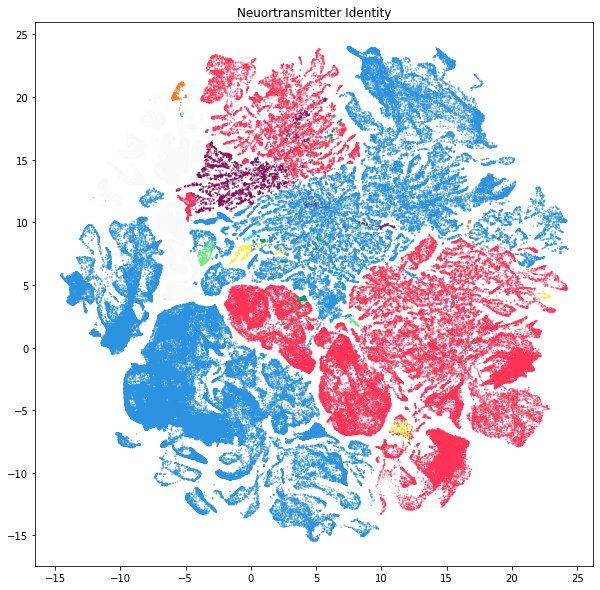

In [15]:
fig, ax = plot_umap( cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")

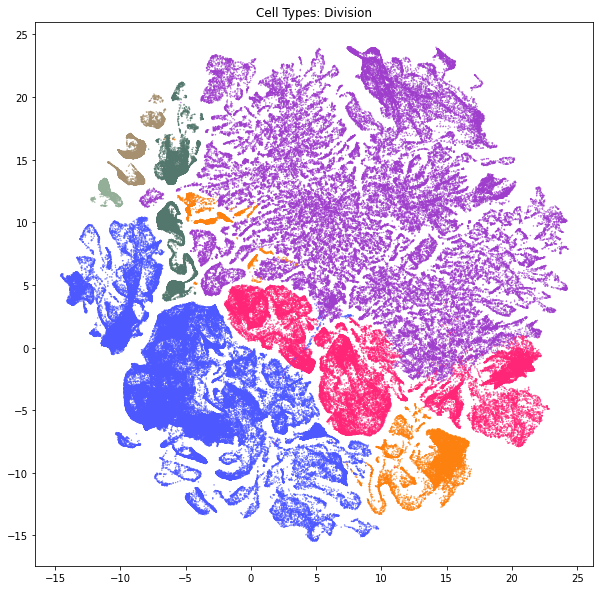

In [16]:
fig, ax = plot_umap( cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['division_color'])
res = ax.set_title("Cell Types: Division")

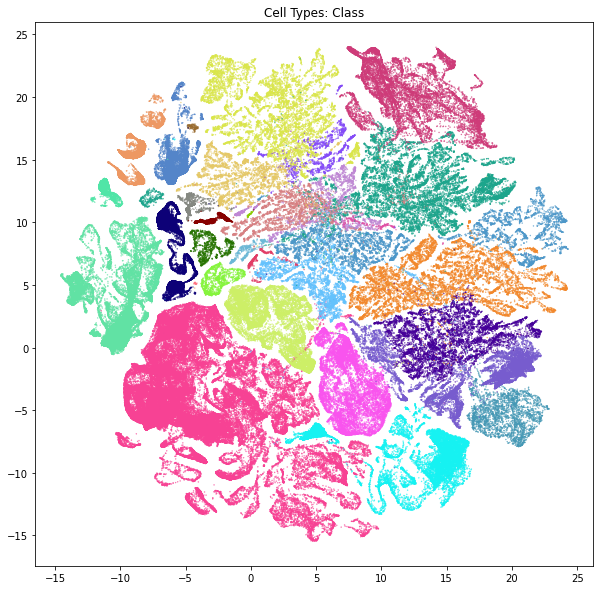

In [17]:
fig, ax = plot_umap( cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['class_color'])
res = ax.set_title("Cell Types: Class")

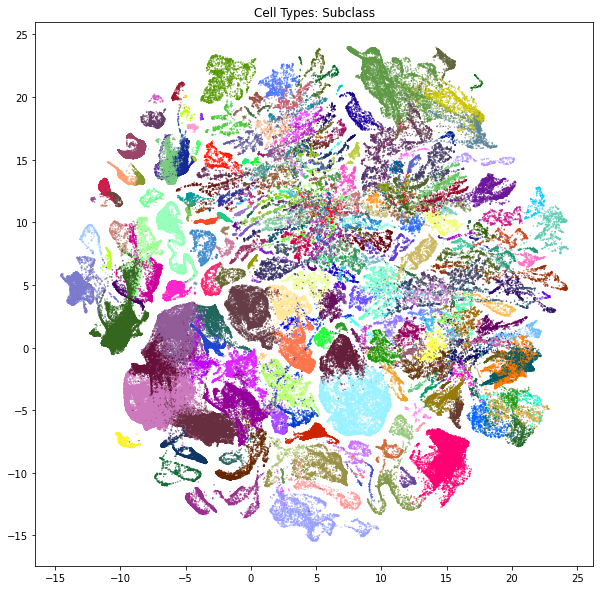

In [18]:
fig, ax = plot_umap( cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['subclass_color'])
res = ax.set_title("Cell Types: Subclass")

### Gene expression matrices

The large 4 million cell dataset has been divided into 23 packages to make data transfer and download more efficient. Each package is formatted as annadata h5ad file with minimal metadata. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.

For each subset, there are two h5ad files one storing the raw counts and the other log normalization of it. The file name has the pattern "dataset/release/matrix_prefix-normalization.h5ad".

In [19]:
expression_directory = os.path.join(input_base, 'expression_matrices')
dataset_label = 'WMB-10Xv2'
release = '20230630'
matrix_prefix = 'WMB-10Xv2-TH'
ext = 'h5ad'
normalization = 'log2'

file = os.path.join( expression_directory, dataset_label, release, '%s-%s.%s'% (matrix_prefix,normalization,ext) )
print(file)

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad


We use the anndata's *read_h5ad* function to open the package for the log2 normalization file. The "backed='r'" makes use of the lazy loading functionality to only load required data. By default, anndata will load the entire expression matrix in memory.

In [20]:
adata = anndata.read_h5ad(file,backed='r')
print(adata)

AnnData object with n_obs × n_vars = 131212 × 32285 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


Genes are represented as "variables". For this data, the *var* dataframe is indexed by the Ensembl gene identifier with one metadata column *gene symbol*.

In [21]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  32285


Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102331',
       'ENSMUSG00000102343', 'ENSMUSG00000025900'],
      dtype='object', name='gene_identifier')

Cells are represented as "observations". For this data, the *obs* dataframe is index by *cell label* with three minimal metadata columns *cell barcode*, *library label* and *anatomical division label*. 

In [22]:
print("Number of cells = ", len(adata.obs))
adata.obs.index[0:5]

Number of cells =  131212


Index(['CAGGTGCAGGCTAGCA-040_C01', 'TGCGCAGGTTGCGCAC-045_C01',
       'CGATGTATCTTGCCGT-042_B01', 'GACTAACGTCCTCTTG-040_B01',
       'GATCGTACAACTGCTA-040_B01'],
      dtype='object', name='cell_label')

We can easily connect the cells in the package to the extended cell metadata with simple pandas filtering.

In [23]:
cell_filtered = cell_extended.loc[adata.obs.index]
print("Number of cells = ", len(cell_filtered))
print_column_info( cell_filtered )

Number of cells =  131212
Number of unique library_label = 26 ['L8TX_180815_01_A07', 'L8TX_180815_01_A08', 'L8TX_180815_01_B07', 'L8TX_180815_01_B08', 'L8TX_180815_01_C07', 'L8TX_180815_01_C08', 'L8TX_180815_01_D07', 'L8TX_180815_01_D08', 'L8TX_180815_01_E07', 'L8TX_180815_01_E08', 'L8TX_180815_01_F07', 'L8TX_180815_01_F08', 'L8TX_180815_01_G07', 'L8TX_180815_01_G08', 'L8TX_180815_01_H07', 'L8TX_180815_01_H08', 'L8TX_180829_01_A09', 'L8TX_180829_01_B09', 'L8TX_180829_01_C09', 'L8TX_180829_01_C10', 'L8TX_180829_01_E09', 'L8TX_180829_01_F09', 'L8TX_180829_01_G09', 'L8TX_190321_01_F03', 'L8TX_190321_01_G03', 'L8TX_190321_01_H03']
Number of unique anatomical_division_label = 1 ['TH']
Number of unique cluster_alias = 1082 
Number of unique library_method = 1 ['10Xv2']
Number of unique region_of_interest_acronym = 1 ['TH']
Number of unique donor_label = 8 ['Snap25-IRES2-Cre;Ai14-404122', 'Snap25-IRES2-Cre;Ai14-404123', 'Snap25-IRES2-Cre;Ai14-404124', 'Snap25-IRES2-Cre;Ai14-404125', 'Snap25-I

## Example use cases

In this section, we explore two use cases. The first example looks at the expression of nine canonical neurotransmitter transporter genes and the second the expression of gene Tac2.

To support these use cases, we will create a smaller submatrix (all cells and 10 genes) that read it into memory. *Note this operation takes around 10 seconds*.

In [24]:
ntgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc18a3','Slc6a3','Slc6a4','Slc6a2']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol
gene_identifier,
ENSMUSG00000037771,Slc32a1
ENSMUSG00000070570,Slc17a7
ENSMUSG00000039728,Slc6a5
ENSMUSG00000030500,Slc17a6
ENSMUSG00000055368,Slc6a2
ENSMUSG00000019935,Slc17a8
ENSMUSG00000025400,Tac2
ENSMUSG00000020838,Slc6a4
ENSMUSG00000021609,Slc6a3


In [25]:
start = time.process_time()
asubset = adata[:,gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  5.77490030700001
AnnData object with n_obs × n_vars = 131212 × 10
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


We define two helper functions to (1) *create_expression_dataframe*: create joined gene expression and cell metadata dataframe based for a set of input genes and (2) *aggregate_by_metadata* which computes the average expression for each term in a given category.

In [26]:
def create_expression_dataframe( ad, gf ) :
    gdata = ad[:,gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = cell_filtered.join( gdata )
    return joined

In [27]:
def aggregate_by_metadata( df, gnames, value, sort=False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes in the thalamus

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of cells in the 'WMB-10Xv2-TH' package and expression of the 9 solute carrier family genes. We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table

Within the thalamus, Slc17a7 is most enriched in cholinergic assigned cells with some expression in glutamatergic types. Genes Slc17a6 and Slc17a8 are enriched in glutamatergic, Slc32a1 in GABAergic, Slc6a5 in cholinergic and Slc6a3 in dopaminergic types, matching the expectation described in the manuscript.

In [28]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe( asubset, gf )
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg = agg[ntgenes]
agg.style.background_gradient(cmap='Reds')

,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc18a3,Slc6a3,Slc6a4,Slc6a2
neurotransmitter,,,,,,,,,
Chol,8.608787,6.528627,0.042500,0.087876,0.005719,3.322996,0.000000,0.011684,0.000000
Dopa,0.604825,3.615892,0.000000,0.757809,0.000000,0.000000,5.524069,0.000000,0.000000
GABA,0.419043,1.216959,0.032728,7.164396,0.026049,0.000960,0.016119,0.011204,0.001380
GABA-Glyc,0.292678,1.885634,0.000000,6.367074,3.755787,0.000000,0.125798,0.000000,0.000000
Glut,3.403658,8.989318,0.233407,0.083664,0.035956,0.025051,0.003759,0.009094,0.001436
Glut-GABA,0.000000,4.691283,0.000000,5.473776,0.000000,0.000000,0.000000,0.000000,0.000000
Hist,0.155022,1.174037,0.052135,0.108541,0.000000,0.000000,0.000000,0.000000,0.000000


### Expression of Tachykinin 2 (Tac2) in the thalamus

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising of cells in the 'WMB-10Xv2-TH' package and expression values of Tac2 in those cells.

In [29]:
gf = asubset.var[asubset.var.gene_symbol == 'Tac2']
tac2 = create_expression_dataframe( asubset, gf )

Grouping cells by neurotransmitter identites and computing the mean expression in each group, we can observed that Tac2 gene is highly enriched in cholinergic cell types.

In [30]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'neurotransmitter', True).head(10)
agg.style.background_gradient(cmap='Reds')

,Tac2
neurotransmitter,
Chol,7.225159
Glut,0.191328
GABA-Glyc,0.129728
Hist,0.055357
GABA,0.041769
Dopa,0.000000
Glut-GABA,0.000000


Grouping cells by cell types class, shows that Tac2 is enriched in class "08 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic types.

In [31]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'class', True).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
class,
08 MH-LH Glut,4.477652
22 MY GABA,0.540533
01 IT-ET Glut,0.424430
17 P Glut,0.384413
06 CNU GABA,0.114376
27 Pineal Glut,0.098581
28 Astro-Epen,0.071376
16 MB Glut,0.066691


At the next level, grouping by subclass, shows Tac2 is enriched in sublcass "063 MH Tac2 Glut" with further specificity to the medial habenula and with Tac2 itself as a marker for the subclass.

In [32]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'subclass',True).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
subclass,
063 MH Tac2 Glut,6.219506
171 PB-an-do Evx2 Glut,3.459718
193 PAS-MV Ebf2 Gly-Gaba,1.297280
197 PAG-MRN Rln3 Gaba,1.260279
045 STRv Lhx8 Gaba,0.944707
047 NDB-SI-MA-STRv Lhx8 Gaba,0.646565
293 CHOR NN,0.435719
012 MEA Slc17a7 Glut,0.424430


Next level down, gene Tac2 is enriched in several children supertypes of "063 MH Tac2 Glut" with the exception of "0252 MH Tac2 Glut_5".

In [33]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'supertype',True).head(10)
agg.style.background_gradient(cmap='Reds')

,Tac2
supertype,
0249 MH Tac2 Glut_2,7.927101
0700 PB-an-do Evx2 Glut_4,6.919436
0248 MH Tac2 Glut_1,6.699828
0250 MH Tac2 Glut_3,6.265915
0182a NDB-SI-MA-STRv Lhx8 Gaba_8,3.556106
0251 MH Tac2 Glut_4,2.401563
0172 STRv Lhx8 Gaba_1,1.322590
0783 PAS-MV Ebf2 Gly-Gaba_1,1.297280
0790 PAG-MRN Rln3 Gaba,1.260279


In [34]:
adata.file.close()